#Estimating GPD parameters




_________________

In [3]:
install.packages("evd")
library(evd)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘evd’


The following objects are masked from ‘package:extRemes’:

    fbvpot, mrlplot


The following objects are masked from ‘package:SpatialExtremes’:

    dgev, dgpd, pgev, pgpd, profile2d, qgev, qgpd, rgev, rgpd




In [2]:
install.packages("SpatialExtremes")
install.packages("extRemes")
library(SpatialExtremes)
library(extRemes)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dotCall64’, ‘Rcpp’, ‘spam’, ‘maps’, ‘fields’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppArmadillo’, ‘Lmoments’, ‘distillery’


Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot




## 0. Data
We generate our dataset out of independent data from a Fréchet distribution

In [ ]:
shape_real <- 1/3
loc_real <- 1
scale_real <- 1/3
n <- 6 * 1e3

samples <- rgev(n, loc = loc_real, shape = shape_real, scale = scale_real)
zoomed_samples <- samples[samples < 10]

ERROR: ignored

In [4]:
### when using in our study
gauge = 8
data <- read.csv("/content/River Flow Observations X.csv")
ind <- which( apply( is.na(data), 1, max ) == 0 )
data   <- data[ind,]
samples <-  data[, gauge]
print(quantile(samples, 0.94))

Warning message in file(file, "rt"):
“cannot open file '/content/River Flow Observations X.csv': No such file or directory”


ERROR: ignored

In [5]:
#with the cluster
data <- read.csv("/content/River Flow Observations X.csv")
ind <- which( apply( is.na(data), 1, max ) == 0 )
data   <- data[ind,]
clusters = read.csv("/content/clusters.csv")
clusters

Warning message in file(file, "rt"):
“cannot open file '/content/River Flow Observations X.csv': No such file or directory”


ERROR: ignored

In [ ]:
l <- list()
#[ 2,  4, 5,  6,  7,  8,  9, 10] pick a cluster among those numbers
cluster <- 10
for (i in 1:45) {
  if (clusters[i] == cluster){
    l <- append(l,i)
  }
}
l

     94% 
1.626031 


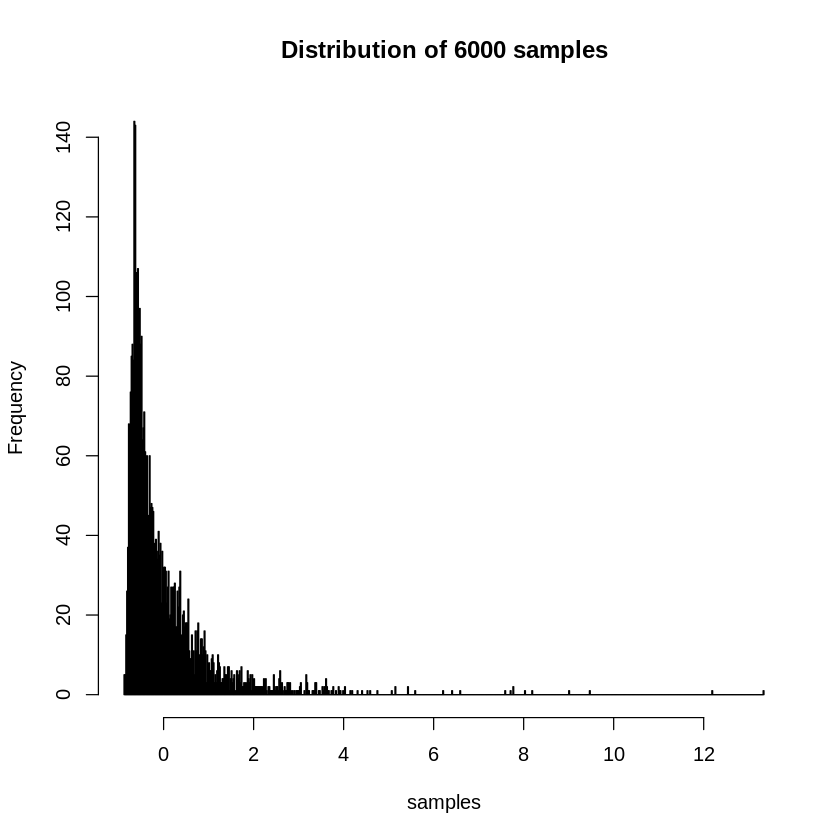

In [ ]:
# Set up a 2x2 grid for plots
print(quantile(samples, 0.94))
par(mfrow = c(1, 1))

# Create and plot multiple graphs
hist(samples, breaks = 1000, main = paste("Distribution of", n, 'samples'))
#hist(zoomed_samples, breaks = 1000, main = "Zoom in samples lower then 10")

# Reset the layout to default (1 plot)
par(mfrow = c(1, 1))


## 1. Fitting of a GPD

### Choice of threshold t

Stability plot can be visualize to verify the threshold set

In [ ]:
# Set up a 2x2 grid for plots
par(mfrow = c(1, 1))

# Create and plot multiple graphs
mrlplot(samples, main = paste("Mean Residual Life plot"))
tcplot(samples, tlim = c(1,7), std.err = FALSE)
# Reset the layout to default (1 plot)
par(mfrow = c(1, 1))


In [ ]:
### Number of samples above t:
t = quantile(samples, 0.94)
excess_samples = samples[samples > t]
cat("Number of excess in our data:", length(excess_samples), '\n')
proportion <- length(excess_samples) / length(samples)
cat("Proportion of the excess in our data: ", proportion, "\n")

In [ ]:
fp <- fevd(samples, threshold = t, type = 'GP', method = "MLE")
#the mle parameters will be stored in fp$estimate
fp


fevd(x = samples, threshold = t, type = "GP", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  297.5863 


 Estimated parameters:
   scale    shape 
1.100175 0.176267 

 Standard Error Estimates:
     scale      shape 
0.10748005 0.07350658 

 Estimated parameter covariance matrix.
             scale        shape
scale  0.011551960 -0.004969736
shape -0.004969736  0.005403218

 AIC = 599.1727 

 BIC = 606.0833 

In [ ]:
scale = as.numeric(fp$results$par['scale'])
shape = as.numeric(fp$results$par['shape'])
cat('scale:', scale, 'shape:', shape)

scale: 1.100175 shape: 0.176267

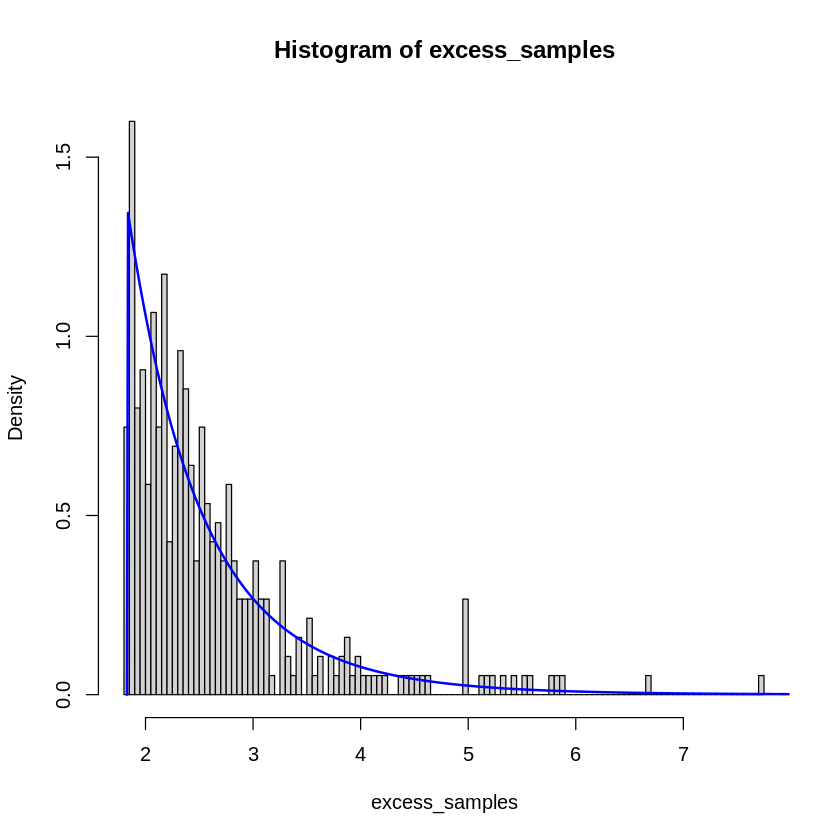

In [ ]:
x <- seq(0, 40, by = 0.01)
density <- dgpd(x, shape = shape, scale = scale)
hist(excess_samples, breaks = 200, freq = FALSE)
lines(x  + t, density, type = "l", col = "blue", lwd = 2, xlab = "X", ylab = "Density",
     main = "Pareto Density Plot")

### Function

In [ ]:
#[ 2,  4,  5,  6,  7,  8,  9, 10]

get_gauges <- function(cluster, clusters){
  l <- list()
  for (i in 1:45) {
    if (clusters[i] == cluster){
      l <- append(l,i)
    }
  }
  return(l)
}

In [ ]:
parameters_clusters <- function(data, clusters, cluster){
  l <- get_gauges(cluster, clusters)
  th <- list()
  samples <- c()
  for (i in 1:length(l)){
    samples <- c(samples, scale(data[, as.numeric(l[i])], center = TRUE, scale = TRUE))
    th <- append(th, quantile(scale(data[, as.numeric(l[i])], center = TRUE, scale = TRUE), 0.94))
  }
  t <- min(unlist(th))
  print(length(samples[samples > t]))
  fp <- fevd(samples, threshold = t, type = 'GP', method = "MLE")
  scale = as.numeric(fp$results$par['scale'])
  shape = as.numeric(fp$results$par['shape'])
  return(list(summary(fp), t))
}

In [ ]:
parameters_clusters(data, clusters, 6)

[1] 290

fevd(x = samples, threshold = t, type = "GP", method = "MLE")

[1] "Estimation Method used: MLE"


 Negative Log-Likelihood Value:  364.6081 


 Estimated parameters:
    scale     shape 
1.1057460 0.1567493 

 Standard Error Estimates:
     scale      shape 
0.09587285 0.06445159 

 Estimated parameter covariance matrix.
             scale        shape
scale  0.009191603 -0.003901972
shape -0.003901972  0.004154008

 AIC = 733.2163 

 BIC = 740.556 


,scale,shape
scale,0.009191603,-0.003901972
shape,-0.003901972,0.004154008


In [ ]:
parameters_clusters(data, clusters, 2)